# Lecture 2 Fast Fourier Transform and Fourier Spectral Method

## Top 10 algorithms for science and engineering. 
##                   -- January/February 2000 issue of Computing in Science and Engineering, Jack Dongarra and Francis Sullivan 

- Newton and quasi-Newton methods,
- Matrix factorizations (LU, Cholesky, QR)
- SVD, QR and QZ algorithms,
- Monte-Carlo methods,
- Fast Fourier transform,
- Krylov subspace methods,
- JPEG,
- PageRank,
- Simplex method, and
- Kalman filter.

Reference 
- https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html
- https://github.com/cpraveen/chebpy
- Chapter 3, Spectral methods in MATLAB, by L. N. Trefethen

# Fast Fourier Transform

<img src="https://history.computer.org/pioneers/images/cooley.jpg" width=150 height=200/>

<img src="https://csml.princeton.edu/sites/g/files/toruqf911/files/styles/freeform_750w/public/pages/tukey_3.jpg" width=250 height=200/>

The Fast Fourier Transform (FFT) is an efficient algorithm to calculate the DFT of a sequence. It is described first in Cooley and Tukey’s classic paper in 1965, but the idea actually can be traced back to Gauss’s unpublished work in 1805. It is a divide and conquer algorithm that recursively breaks the DFT into smaller DFTs to bring down the computation. As a result, it successfully reduces the complexity of the DFT from \(O(n^2)\) to \(O(nlogn)\), where \(n\) is the size of the data. This reduction in computation time is significant especially for data with large \(N\), therefore, making FFT widely used in engineering, science and mathematics. The FFT algorithm is the Top 10 algorithm of 20th century by the journal Computing in Science & Engineering.


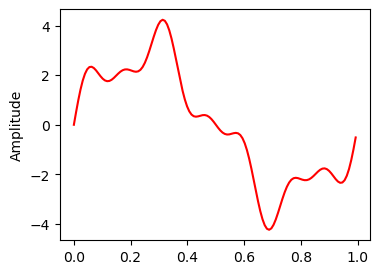

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# sampling rate
sr = 128
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x1 = 3*np.sin(2*np.pi*freq*t)

freq = 4
x1 += np.sin(2*np.pi*freq*t)

freq = 7   
x1 += 0.5* np.sin(2*np.pi*freq*t)

plt.figure(figsize = (4, 3))
plt.plot(t, x1, 'r')
plt.ylabel('Amplitude')

plt.show()


In [2]:
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

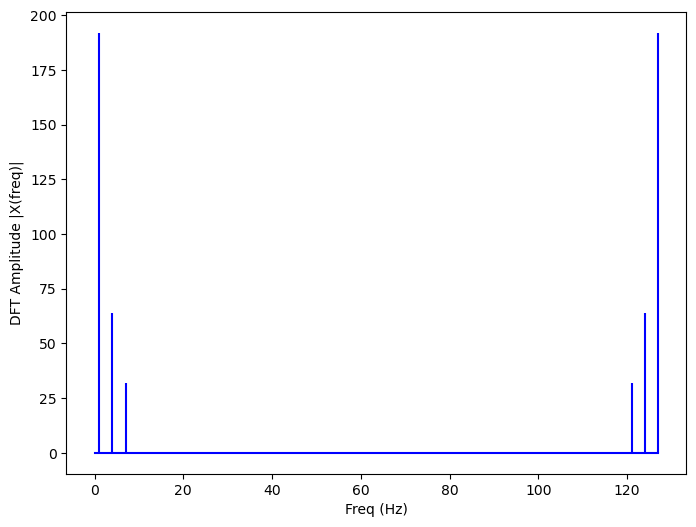

In [3]:
X = DFT(x1)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (8, 6))
plt.stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.show()


In [4]:
def gen_sig(sr):
    '''
    function to generate
    a simple 1D signal with
    different sampling rate
    '''
    ts = 1.0/sr
    t = np.arange(0,1,ts)

    freq = 1.
    x = 3*np.sin(2*np.pi*freq*t)
    return x


In [5]:
# sampling rate =2048
sr = 2048
%timeit DFT(gen_sig(sr))


85.8 ms ± 4.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Cooley-Tukey find Fast Fourier Transform,and we call it Cooley-Tukey Algorithm, and its cost can be $O(N\log_2 N)$
	
Set $\omega = e^{\frac{2\pi i}{N}}$,$N=2^m$
	
$$
	\begin{aligned}
	G_n &= \sum^{N-1}_{k=0} e^{2\pi i \frac{nk}{N}} g_k\\	
	& =\sum^{\frac{N}{2}-1}_{k=0} e^{2\pi i \frac{2nk}{N} } g_{2k} + \sum^{\frac{N}{2}-1}_{k=0} e^{2\pi i \frac{n(2k+1)}{N} } g_{2k+1} \\
	& =\sum^{\frac{N}{2}-1}_{k=0} e^{2\pi i \frac{nk}{\frac{N}{2}}} g_{2k} + 
	\omega^n \sum^{\frac{N}{2}-1}_{k=0} e^{2\pi i \frac{nk}{\frac{N}{2}}} g_{2k+1}\\	
	&=G_n^e + \omega^n G_n^o ,n=0,1,...N-1
	\end{aligned}
$$

Where
- $G^e_n$: DFT of data with even subscripts, length is $\frac{N}{2}$;
- $G^e_o$: DFT of data with odd subscripts , length is $\frac{N}{2}$;
- $G^e_{n+\frac{N}{2}}=G^e_n$,$G^o_{n+\frac{N}{2}}=G^o_n$.
	
we can continue to do like this
	
At last we get $2^N G_n^{}$ , each of them corresponds to one $g_k$ . We know one data's Fourier Transform is itself, so we can say $g_0=G_n^{ee..e}$ and so on.

But this is not enough, we need a butterfly algorithm. For details, see Chapter 12 of Numerical Recipe. http://numerical.recipes/book/book.html

<img src="https://pic4.zhimg.com/80/v2-d92edb40d6e2fce34bbf8d2428ce803f_1440w.jpg" height=300/>


In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-poster')
%matplotlib inline


/var/folders/pp/wv25t6qx0s5b8l0s8ty2904c0000gn/T/ipykernel_94045/2378172170.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [7]:
def FFT(x):
    """
    A recursive implementation of 
    the 1D Cooley-Tukey FFT, the 
    input should have a length of 
    power of 2. 
    """
    N = len(x)
    
    if N == 1:
        return x
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = \
          np.exp(-2j*np.pi*np.arange(N)/ N)
        
        X = np.concatenate(\
            [X_even+factor[:int(N/2)]*X_odd,
             X_even+factor[int(N/2):]*X_odd])
        return X


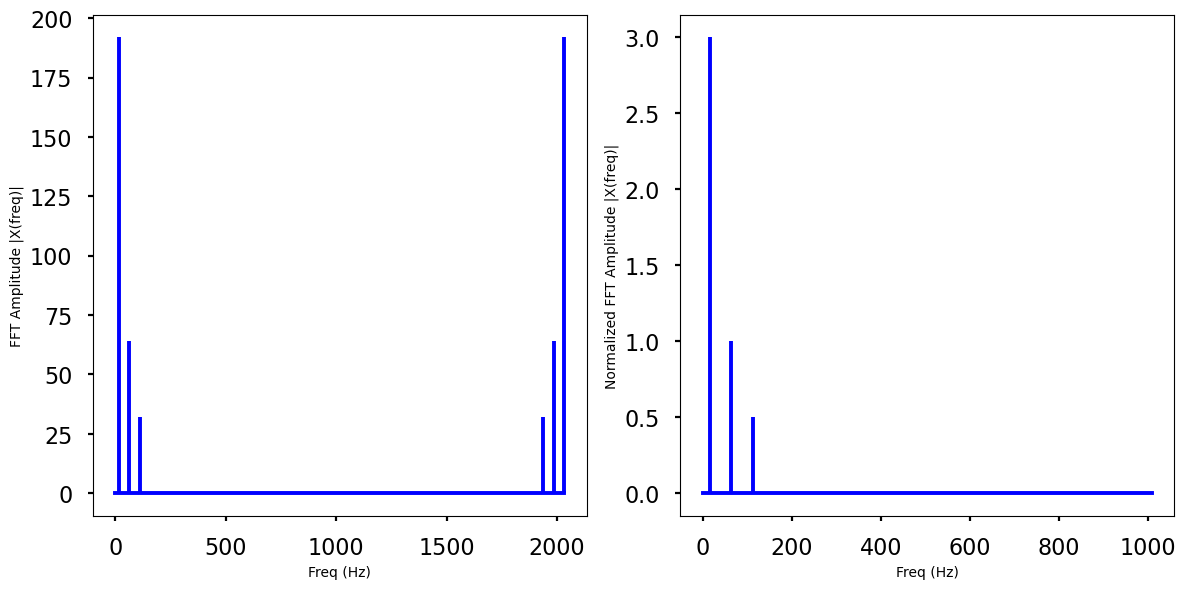

In [8]:
X=FFT(x1)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

# Get the one-sided specturm
n_oneside = N//2
# get the one side frequency
f_oneside = freq[:n_oneside]

# normalize the amplitude
X_oneside =X[:n_oneside]/n_oneside

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('Normalized FFT Amplitude |X(freq)|')
plt.tight_layout()
plt.show()


In [9]:
def gen_sig(sr):
    '''
    function to generate
    a simple 1D signal with
    different sampling rate
    '''
    ts = 1.0/sr
    t = np.arange(0,1,ts)

    freq = 1.
    x = 3*np.sin(2*np.pi*freq*t)
    return x


In [10]:
# sampling rate =2048
sr = 2048
%timeit FFT(gen_sig(sr))


21 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Exercise 5** Generate a simple signal for length 2048, and time how long it will run the FFT and compare the speed with the DFT.

**EXAMPLE** Use fft and ifft function from numpy to calculate the FFT amplitude spectrum and inverse FFT to obtain the original signal. Plot both results. Time the fft function using this 2000 length signal.



/Users/work/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


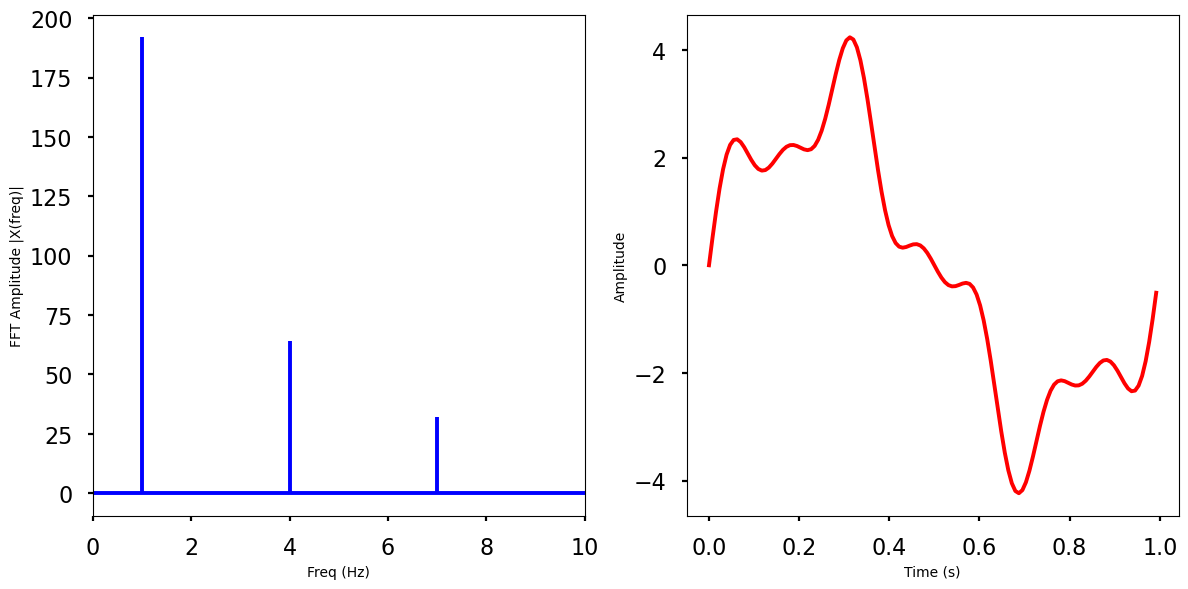

In [11]:
from numpy.fft import fft, ifft

sr = 128
X = fft(x1)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [12]:
%timeit fft(gen_sig(2048))

36.9 µs ± 185 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# FFT in Scipy

**Example** Use fft and ifft function from scipy to calculate the FFT amplitude spectrum and inverse FFT to obtain the original signal. Plot both results. Time the fft function using this 2048 length signal.

/Users/work/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


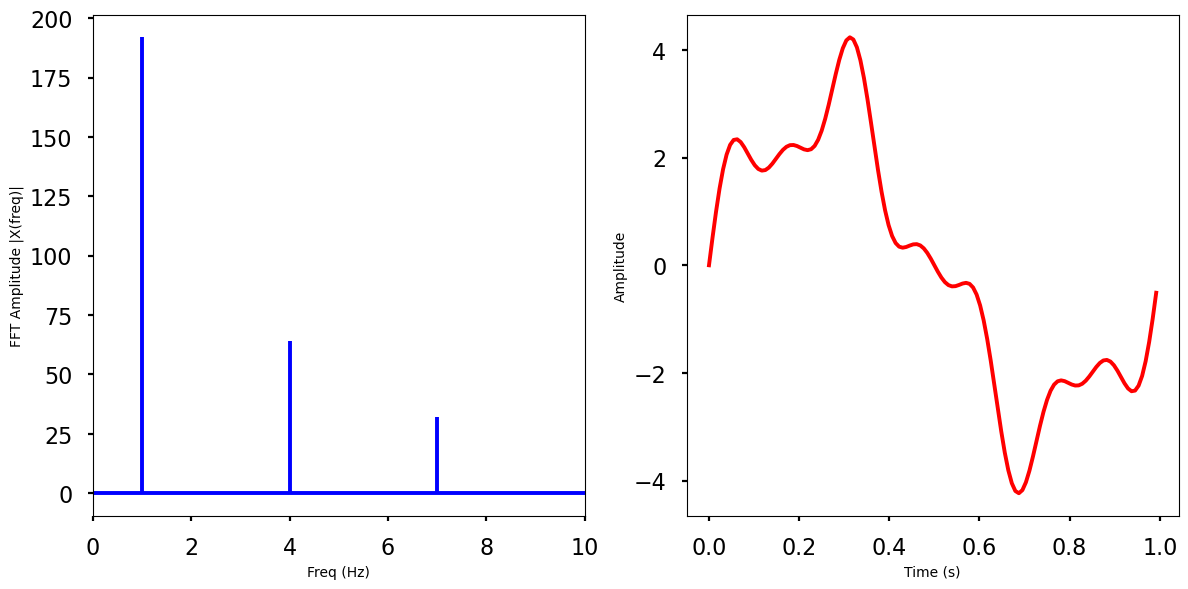

In [13]:
from scipy.fftpack import fft, ifft

X = fft(x1)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(X), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


In [14]:
%timeit fft(gen_sig(2048))

33.8 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**Exercise 6** For signals of length 2^[6:16], try fft with DFT, FFT, scipy.fft, numpy.fft, plot the time vs. length with log-log plot.

# Periodic Interpolation & DFT
Let $h=2\pi/N$, the formula for DFT be 
$$ \hat{v}_k = h\sum_{j=1}^N \exp{(-ikx_j)}v_j$$
with wave numbers $k=-N/2+1,\dots, N/2$.
and the inverse DFT is given by 
$$ v_j = \frac{1}{2\pi} \sum_{k=-N/2+1}^{N/2} \exp{(ikx_j)}\hat{v}_k,$$
with spatial indices $j=1,\dots, N$. This can be represented as 
$$ v_j = \frac{1}{2\pi} \sum_{k=-N/2}^{N/2} \exp{(ikx_j)}\hat{v}_k,$$
with $\hat{v}_{-N/2} = \hat{v}_{N/2}$.

This can be used to dervie a band-limited interpolation with the form 
$$p(x) = \frac{1}{2\pi}\sum_{k=-N/2}^{N/2} \exp{(ikx)}\hat{v}_k, \quad x\in[0,2\pi]$$
namely, it can be written as a linear combination of functions $1$, $\sin(x)$, $\cos(x)$, $\sin(2x)$, ..., $\sin(Nx/2)$, $\cos(Nx/2)$. (actually, the $\sin(Nx/2))$ term is not needed, since its grid value is $0$).

# Band-limited interpolant of the delta function

The (periodic) delta function 
$$\delta_j = \left\{
        \begin{array}{cc}
            1, & j\equiv 0 (mod N),\\
            0, & j\not\equiv 0 (mod N).
        \end{array}
    \right.
$$

We have $\hat{\delta}_k=h$ for each $k$, and we get the band limited interpolation of the delta function as
$$ 
\begin{aligned}
p(x) & = \frac{h}{2\pi}\sum^{N/2}_{k=-N/2}\exp(ikx) \\
        & = \frac{h}{2\pi}\Big(\frac12\sum^{N/2-1}_{k=-N/2}\exp(ikx)+\frac12\sum^{N/2}_{k=-N/2+1}\exp(ikx)\Big)\\
        & = \frac{h}{2\pi} \cos(x/2) \sum^{N/2-1/2}_{k=-N/2+1/2}\exp(ikx)\\
        & = \frac{n}{2\pi} \cos(x/2) \frac{\exp(i(-N/2+1/2)x)-\exp(i(N/2+1/2)x)}{1-\exp(ix)}\\
        & = \frac{n}{2\pi} \cos(x/2) \frac{\exp(i(-N/2)x)-\exp(i(N/2)x)}{\exp(-ix/2)-\exp(ix/2)}\\
        & = \frac{h}{2\pi}\cos(x/2)\frac{\sin(Nx/2)}{\sin(x/2)}
\end{aligned}
$$

We conclude that the band-limited interpolant to $\delta$ is the periodic sinc function $$S_N:=\frac{\sin(\pi x/h)}{(2\pi/h)\tan(x/2)}.$$

Thus the band-limited interpolant of $v(x)$ can be written as $$p(x) = \sum_{m=1}^N v_m S_N(x-x_m)$$.

The derivative of the periodic sinc function at a grid point is 
$$S'_N(x_j)  = \left\{
        \begin{array}{cc}
            0, & j\equiv 0 (mod N),\\
            \frac12 (-1)^j \cot(jh/2), & j\not\equiv 0 (mod N).
        \end{array}
    \right.
$$

Using the above formula we can get $p'(x)$ with the following differentiation matrix derived in the previous lecture,
$$
D =  \left( {\begin{array}{ccccccccc}
     &  &  &  & \vdots &  &  &  &  \\
     &  &  \ddots &  & \frac12\cot{\frac{3h}{2}} &  &  & & \\
     &  &  \ddots &  & -\frac12\cot{\frac{2h}{2}} &  &  & & \\
     &  &  \ddots &  & \frac12\cot{\frac{h}{2}} &  &  & & \\
     &  &  &  & 0 &  &  & & \\
     &  &  &  & -\frac12\cot{\frac{1h}{2}} &  & \ddots &  & \\
     &  &  &  & \frac12\cot{\frac{2h}{2}} &  & \ddots &  & \\
     &  &  &  & -\frac12\cot{\frac{3h}{2}} &  & \ddots &  & \\
     &  &  &  & \vdots &  &  & & \\
  \end{array} } \right)
$$

## Remark
Higher spectral derivatives can be computed by  differentiating the interpolant $p(x)$, and obtaining higher order spectral differentiation matrices. 

# Periodic spectral differentiation

We compute derivatives of following periodic functions on finite interval
$$
v(x) = \max(0, 1-|x-\pi|/2), \qquad x \in [0,2\pi]
$$
and
$$
v(x) = \exp(\sin(x)), \qquad x \in [0,2\pi]
$$

In [15]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
from numpy import pi,inf,linspace,zeros,arange,sin,cos,tan,exp,maximum,abs
from numpy.linalg import norm
from scipy.linalg import toeplitz
from matplotlib.pyplot import figure,subplot,plot,axis,title,text

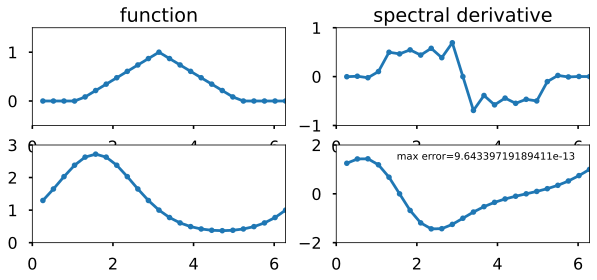

In [16]:
# Set up grid and differentiation matrix:
N = 24; h = 2*pi/N; x = h*arange(1,N+1);
col = zeros(N)
col[1:] = 0.5*(-1.0)**arange(1,N)/tan(arange(1,N)*h/2.0)
row = zeros(N)
row[0] = col[0]
row[1:] = col[N-1:0:-1]
D = toeplitz(col,row)

figure(figsize=(10,6))

# Differentiation of a hat function:
v = maximum(0,1-abs(x-pi)/2)
subplot(3,2,1)
plot(x,v,'.-')
axis([0, 2*pi, -.5, 1.5])
title('function')
subplot(3,2,2)
plot(x,D.dot(v),'.-')
axis([0, 2*pi, -1, 1])
title('spectral derivative')

# Differentiation of exp(sin(x)):
v = exp(sin(x)); vprime = cos(x)*v;
subplot(3,2,3)
plot(x,v,'.-')
axis([0, 2*pi, 0, 3])
subplot(3,2,4)
plot(x,D.dot(v),'.-')
axis([0, 2*pi, -2, 2])
error = norm(D.dot(v)-vprime,inf)
text(1.5,1.4,"max error="+str(error));

# Alternative implementation with FFT
As ever with spectral methods, alternative methods of implementation can be found. In particular, the DFT can be used:
- Given $v$, compute $\hat{v}$
- Define $\hat{w}_k=ik\hat{v}_k$, except $\hat{w}_{N/2}=0$.
- Compute $w$ from $\hat{w}$. 

For higher derivatives we multiply by the appropriate power of $ik$, taking special care of the $\hat{w}_{N/2}$ term. For odd derivatives there is a loss of symmetry and we have to set $\hat{w}_{N/2} = 0$. Otherwise $\hat{w}_{N/2}$ is given by the same formula as the other $\hat{w}_k$. In summary, to approximate the $v$th derivative,
- Given $v$, compute $\hat{v}$
- Define $\hat{w}_k=(ik)^\nu\hat{v}_k$, but $\hat{w}_{N/2}=0$ if $\nu$ is odd.
- Compute $w$ from $\hat{w}$. 

**Exercise 6** 
Explain why special attention is needed for $\hat{w}_{N/2}$.


# Repetition of Program 4 via FFT

In [17]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
#  For complex v, delete "real" commands.
from numpy import pi,inf,linspace,maximum,abs,zeros,arange,real,sin,cos,exp
from numpy.fft import fft,ifft
from numpy.linalg import norm
from matplotlib.pyplot import figure,subplot,plot,axis,title,text

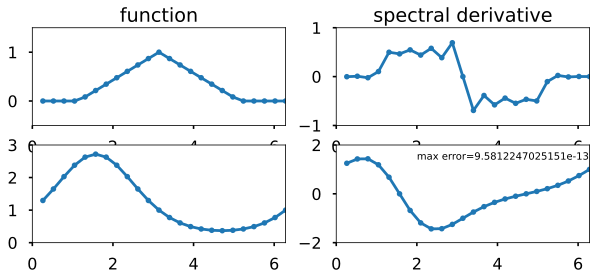

In [18]:
# Set up grid and differentiation matrix:
N = 24; h = 2*pi/N; x = h*arange(1,N+1);

# Differentiation of a hat function:
v = maximum(0.0,1.0-abs(x-pi)/2.0)
v_hat = fft(v)
w_hat = 1j*zeros(N)
w_hat[0:N//2] = 1j*arange(0,N//2)
w_hat[N//2+1:] = 1j*arange(-N//2+1,0,1)
w_hat = w_hat * v_hat
w = real(ifft(w_hat))

figure(figsize=(10,6))

subplot(3,2,1)
plot(x,v,'.-')
axis([0, 2*pi, -.5, 1.5])
title('function')
subplot(3,2,2)
plot(x,w,'.-')
axis([0, 2*pi, -1, 1])
title('spectral derivative')

# Differentiation of exp(sin(x)):
v = exp(sin(x)); vprime = cos(x)*v;
v_hat = fft(v)
w_hat = 1j*zeros(N)
w_hat[0:N//2] = 1j*arange(0,N//2)
w_hat[N//2+1:] = 1j*arange(-N//2+1,0,1)
w_hat = w_hat * v_hat
w = real(ifft(w_hat))
subplot(3,2,3)
plot(x,v,'.-')
axis([0, 2*pi, 0, 3])
subplot(3,2,4)
plot(x,w,'.-')
axis([0, 2*pi, -2, 2])
error = norm(w-vprime,inf)
text(2.0,1.4,"max error="+str(error));

# Spectral Method for PDE
Now we have the spectral tools to solve PDEs. Consider the variable coefficient wave equation,
$$ u_t + c(x) u_x = 0, \quad c(x) = \frac{1}{5}+ \sin^2(x-1)$$
for $x\in [0, 2\pi]$, $t>0$, with periodic boundary condition, and initial condition $u(x,0) = \exp(-100(x-1)^2)$. 

To construct our numerical scheme, we proceed just as we might with a finite difference approximation of a PDE. For the time derivative we use a leap frog formula, and we approximate the spatial derivative spectrally. Let $v^n$ be the vector at time step $n$ that approximates $u(x_j,n\Delta t)$. At grid point $x_j$, our spectral derivative is $(Dv^n)_j$, here $D = D_N$, the spectral differentiation matrix for the N-point equispaced grid, which we implement by the FFT. The approximation becomes
$$ \frac{v_j^{n+1}-v_j^{n-1}}{2\Delta t} = -c(x_j)(Dv^n)_j, \quad j = 1, \cdots, N.$$

To obtain a starting value $v^{-1}$, the Program 6 extrapolates backwards with the assumption of a constant wave speed of $\frac{1}{5}$. This approximation introduces a small error. For more serious work one could use one or more steps of a one-step ordinary differential equation (ODE) formula, such as a Runge-Kutta formula, to generate the necessary second set of initial data at $t=-\Delta t$ or $t=\Delta t$.

In [19]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from numpy import pi,linspace,sin,exp,round,zeros,arange,real
from numpy.fft import fft,ifft
from matplotlib.pyplot import figure

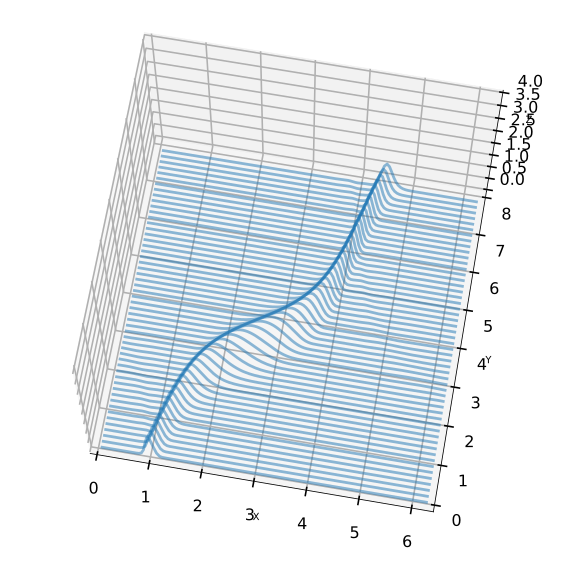

In [20]:
# Program 6
# Set up grid and differentiation matrix:
N = 128; h = 2*pi/N; x = h*arange(1,N+1);
t = 0.0; dt = h/4.0
c = 0.2 + sin(x-1.0)**2.0
v = exp(-100.0*(x-1.0)**2.0); vold = exp(-100.0*(x-0.2*dt-1.0)**2.0);

# Time-stepping by leap-frog formula
tmax = 8.0; tplot = 0.15;
plotgap = int(round(tplot/dt)); dt = tplot/plotgap;
nplots = int(round(tmax/tplot))
data = []
data.append(list(zip(x, v)))
tdata = []; tdata.append(0.0)
for i in range(1,nplots):
    for n in range(plotgap):
        t = t + dt
        v_hat = fft(v)
        w_hat = 1j*zeros(N)
        w_hat[0:N//2] = 1j*arange(0,N//2)
        w_hat[N//2+1:] = 1j*arange(-N//2+1,0,1)
        w_hat = w_hat * v_hat
        w = real(ifft(w_hat))
        vnew = vold - 2.0*dt*c*w
        vold = v; v = vnew;
    data.append(list(zip(x, v)))
    tdata.append(t);

fig = figure(figsize=(12,10))
ax = fig.add_subplot(111,projection='3d')
poly = LineCollection(data)
poly.set_alpha(0.5)
ax.add_collection3d(poly, zs=tdata, zdir='y')
ax.set_xlabel('X')
ax.set_xlim3d(0, 2*pi)
ax.set_ylabel('Y')
ax.set_ylim3d(0, 8)
ax.set_zlabel('Z')
ax.set_zlim3d(0, 4)
ax.view_init(70,-80)

**Exercise 7** 
Recompute the wave equation by a modified program based on the finite difference leap frog formula
$$ \frac{v_j^{n+1}-v_j^{n-1}}{2\Delta t} = -c(x_j)\frac{v^n_{j+1}-v^n_{j-1}}{2\Delta x}, \quad j = 1, \cdots, N.$$
rather than a spectral method. Produce plots for $N = 128$ and $256$.